### Long-period filter for 2019 data: Sector 10 

def: find_nearest(array, value)


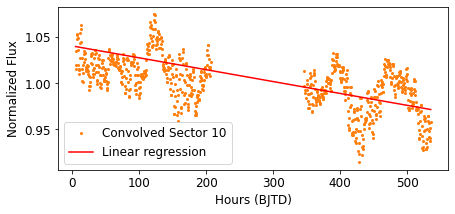

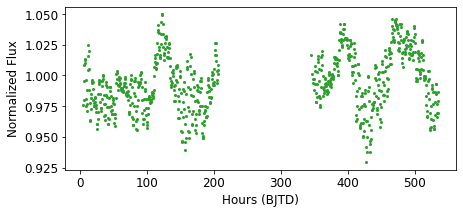

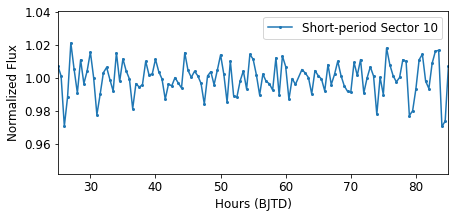

In [21]:
from AROMA import *
from AROMA.utils import *
from AROMA.config import *
import pandas as pd
from scipy.optimize import curve_fit
from statsmodels.graphics.tsaplots import plot_acf
%matplotlib inline

pi = np.pi 

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx
print('def: find_nearest(array, value)')

def gauss(x, u, fwhm):
    sigma = fwhm/2.355
    return 1/(sigma*np.sqrt(2*pi)) * np.exp (-(x-u)**2/(2*sigma**2))

import os
from os.path import join
array = os.path.abspath('').split('/')
homedir = '/'
for i in range(1,7):
   homedir = join(homedir, array[i])
homedir

# data_path = '~/Documents/GitHub/aroma/AROMA_An_Exo_Rot_Mapping/data/processed/luhman_16ab_sector36-37_longPeriodsRemoved.txt'
data_path = '~/Documents/GitHub/aroma/AROMA_An_Exo_Rot_Mapping/data/Lu16_TESS_preprocessed_positions.txt'

header = ['time','flux','local_sky','xpos','ypos','dflag']
dataRaw = pd.read_csv(data_path, names=header, delimiter=',',skiprows=1)

plotPath = join(homedir, 'plots')
fit_dir = join(homedir,'notebooks', 'periodSineFit_metadata')

### Light curve cleaning: CORRECT METHOD
skyLOCALnoise = 140 #(e s^-1)

data = dataRaw.query("dflag == 0 & local_sky<=%f & local_sky>=%f"%(skyLOCALnoise, 50))

data.time = (data.time-data.time.iloc[0])*24

sky_threshold = dataRaw.local_sky.mean() + 4*dataRaw.local_sky.std()
data = data.query("local_sky<=%f"%(sky_threshold))
data['normflux'] = data.flux/data.flux.mean()

# Fit linear regression

# Smoothing for data
from astropy.convolution import convolve, Box1DKernel
data.flux = convolve(data.normflux, Box1DKernel(5))
data = data.query('time>4.6 & time <535.08')

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 12}) 

plt.figure(figsize=(7,3))
plt.plot(data.time, data.flux, 
         ls='', marker='o', ms=2, c ='tab:orange', label='Convolved Sector 10')

regression = -1.28e-4*data.time + 1.04
plt.plot(data.time, regression, 'r', label='Linear regression')
plt.ylabel('Normalized Flux'), plt.xlabel('Hours (BJTD)'), plt.legend()
# plt.ylim((0.93, 1.06))

plt.figure(figsize=(7,3))
plt.plot(data.time, 1+data.flux - (regression), 
         ls='', marker='o', ms=2, c ='tab:green', label='De-trended Sector 10')
plt.ylabel('Normalized Flux'), plt.xlabel('Hours (BJTD)')
# plt.legend()
# plt.ylim((0.93, 1.06))

plt.figure(figsize=(7,3))
plt.plot(data.time, 1 + data.normflux - data.flux, 
         ls='-', marker='o', ms=2, c ='tab:blue', label='Short-period Sector 10')
plt.ylabel('Normalized Flux'), plt.xlabel('Hours (BJTD)'), plt.legend()
plt.xlim((25, 85))

data.flux = 1+data.flux - (regression)

# # filter and subtract data: data_raw - [data<20 hours] - [data>125 hours]? 
# # longrate=125

# # data.lc_smooth = data.lc_smooth.rolling(window=rate).median()
# # data = data[::skip]
# # data = data.dropna(axis=0)

# time_old = data.TIME
# time_orig = data.TIME
# lc_orig = data.lc_smooth
# print(len(time_orig))

# ### CHOOSING SEGMENTS TO SUBTRACT
# lower = 60
# shortlc = data.PSF_FLUX_NORM - data.PSF_FLUX_NORM.rolling(window=lower).median()
# # shortlc = shortlc
# upper = 90
# longerlc = data.lc_smooth.rolling(window=upper).median()

# targetlc = data.PSF_FLUX_NORM - shortlc - longerlc
# targetlc += abs(np.min(targetlc))+1
# targetlc /= np.max(targetlc)

# ### EVEN SMOOTHER SUBTRACTED LIGHT-CURVE
# smoother_targetlc = targetlc.rolling(window=25).mean()

# # print('Original shape: ', dataRaw['TIME']'.size)  
# # print('Reduced shape at constant sampling rate=%i: '%rate, data['TIME'].size)  
# # plt.close(), plt.figure()
# data['processedLong'] = targetlc.copy()
# data['processedLongB'] = smoother_targetlc.copy()
# data = data.dropna(axis=0)
# time_new = data.TIME

In [ ]:
### %matplotlib widget
plt.close(), plt.figure(figsize=(12,3))

plt.subplot(121)
plt.plot(data.time, data.xpos, ls='', marker='.', ms=6)
# plt.xlim((0,600)), plt.ylim((540.075, 540.25))
plt.xlabel('Time (hours)'), plt.title('Centroid-X (pixels) Sector 10'), plt.tight_layout()

plt.subplot(122)
plt.plot(data.time, data.ypos, ls='', marker='.', ms=6)
# plt.xlim((600, 1200)), plt.ylim((1.0538e3+0.01, 1.0538e3+0.07))
plt.xlabel('Time (hours)'), plt.title('Centroid-X (pixels) Sector 10'), plt.tight_layout()

### Subtraction Method: remove shortperiod over 20 hours, keep long-period under 125 hours

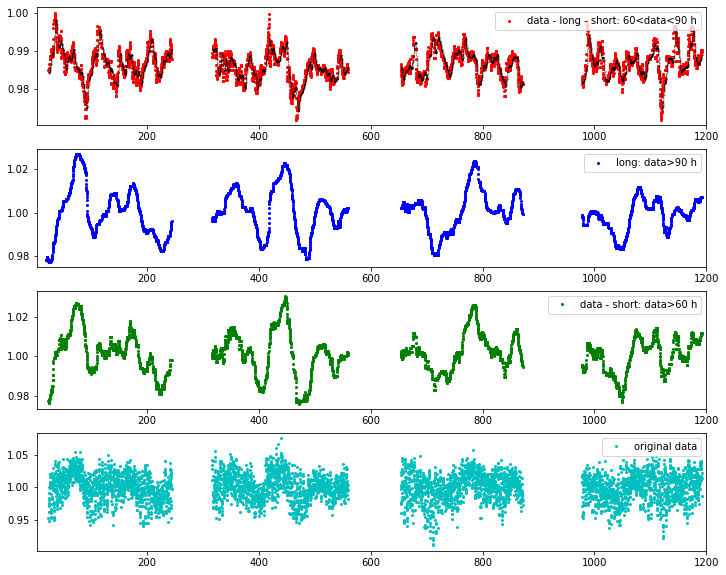

In [50]:
limx=[2,1200]
limy = [0.9, 1.1]
# plt.close()

%matplotlib inline
f, (a,b,c,d) = plt.subplots(4,1, figsize=(12,10))
a.plot(time_new, data.processedLong, ls='', marker='o', ms=2, c='r', label='data - long - short: %i<data<%i h'%(lower, upper))
a.plot(time_new, data.processedLongB, ls='', marker='+', ms=1.0, alpha=0.4, c='k')
a.set_xlim(limx)
a.legend(loc='upper right')
# a.set_ylim([0.98, 1.08])

b.plot(time_old, longerlc, ls='', marker='o', ms=2, c='b', label='long: data>%i h'%upper)
b.set_xlim(limx)
b.legend(loc='upper right')

c.plot(time_old, data.PSF_FLUX_NORM - shortlc, ls='', marker='o', ms=2, c='g', label='data - short: data>%i h'%lower),
c.set_xlim(limx)
c.legend(loc='upper right')
# c.set_ylim(limy)

d.plot(time_new, data.PSF_FLUX_NORM, ls='', marker='o', ms=2, c='c', label='original data')
d.set_xlim(limx)
d.legend(loc='upper right')

# time_orig, lc_orig = data.TIME, data.lc_smooth
segments = [(0, 250), (310, 570), (630, 890), (960, 1200)]

## Fourier Transform: Remove explicit frequency in freq. space

### Fourier Bandpass: Keep 15-100h

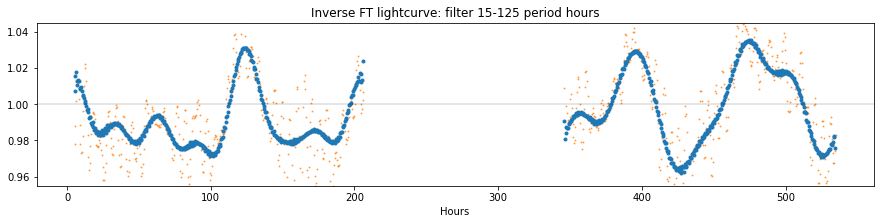

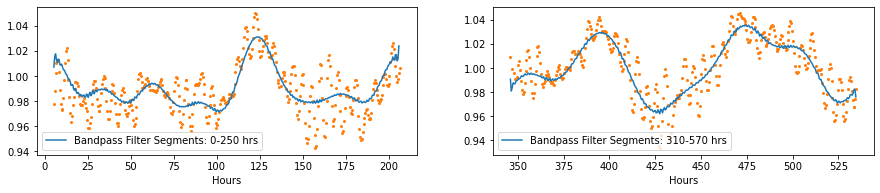

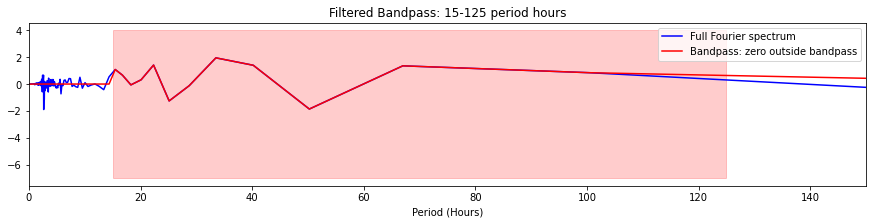

In [31]:
from scipy.fftpack import rfft, irfft, fftfreq
from scipy.interpolate import interp1d
segments = [(0, 250), (310, 570)]
import warnings
warnings.filterwarnings("ignore")

plt.close()
%matplotlib inline
f, ax = plt.subplots(figsize=(15,3))
tempTime, tempData = [], []
fig = plt.figure(figsize=(15, 6))

longPeriod_lc = pd.DataFrame()

OGwindow = 2

for i,seg in enumerate(segments):
    t0, t1 = seg[0], seg[1]
    subset = data.query('time >= %f & time < %f'%(t0, t1))
    realTime = subset.rolling(OGwindow).median().dropna()['time']
    realLc = subset.rolling(OGwindow).median().dropna()['flux']
    cadence = 0.5 # hours

    # synthetic time array and interpolated data
    synTime = np.arange(start=realTime.iloc[0], stop=realTime.iloc[-1], step=cadence)
    N = len(synTime)
    finterp = interp1d(x=realTime, y=realLc, kind = 'cubic')
    synLc = finterp(synTime)
    
    # fourier tranform
    yf = rfft(synLc)
    xf_period = 1/fftfreq(N, cadence)
    xf_freq = fftfreq(N, cadence)

    limlow, limhigh = 15, 125 # period hours, targets periods to extract
    # limlow, limhigh = 15, 95 # period hours, targets periods to extract
    # limlow, limhigh = 15, 45 # period hours, targets periods to extract
    
    boxcarwindow = 1 # period hours, to be smoothed out
    # filtering    
    yf_fil = yf.copy()
    # bandpass filter
    yf_fil[xf_period<0] = 0
    yf_fil[np.logical_and(xf_period>limlow, xf_period<limhigh)] = 0
    yf_fil[np.logical_and(xf_period>-limhigh, xf_period<-limlow)] = 0
    
    # subtract bandpass to get target extraction
    yf_filtered = yf-yf_fil
    filteredLc = pd.DataFrame(irfft(yf_filtered))
    
    if i == 0:
        # plot frequency spectrum
        figure, axe = plt.subplots(figsize=(15, 3))
        axe.set_title('Filtered Bandpass: %i-%i period hours'%(limlow, limhigh))
        axe.plot(xf_period, yf, 'b', label='Full Fourier spectrum')
        axe.plot(xf_period, yf_filtered, 'r', label='Bandpass: zero outside bandpass')
        plt.xlim((0,limhigh+25))
        axe.set_xlabel('Period (Hours)')
        rect = plt.Rectangle((limlow, -7), limhigh-limlow, 4--7, color='r', alpha=0.2)
        axe.add_patch(rect)
        axe.legend()
        
    # plot inverse transform of the frequency-filtered lightcurve
    axes = fig.add_subplot(2, 2, i+1)
    axes.plot(realTime, realLc, ls='', marker='o', ms=2, c='tab:orange')
    if i==0: axes.plot(synTime,0.99+ filteredLc.rolling(boxcarwindow).mean(), c='tab:blue', label='Bandpass Filter Segments: %i-%i hrs'%(t0, t1))
    elif i==1: axes.plot(synTime,1+ filteredLc.rolling(boxcarwindow).mean(), c='tab:blue', label='Bandpass Filter Segments: %i-%i hrs'%(t0, t1))
    axes.set_xlabel('Hours')
    axes.legend()
        
    # ax.plot(synTime, 1+filteredLc.rolling(boxcarwindow).mean(), ls='', marker='o', ms=3, c='tab:blue')
    ax.plot(realTime, realLc, c='tab:orange', ls='', marker='o', ms=1, alpha=0.6)
    if i==0: ax.plot(synTime,0.99+ filteredLc.rolling(boxcarwindow).mean(), ls='', marker='o', ms=3, c='tab:blue')
    elif i==1: ax.plot(synTime,1+ filteredLc.rolling(boxcarwindow).mean(), ls='', marker='o', ms=3, c='tab:blue')
    ax.set_xlabel('Hours')
    ax.set_title('Inverse FT lightcurve: filter %i-%i period hours'%(limlow, limhigh))
    
    temparray = 1+filteredLc.rolling(boxcarwindow).mean()
    tempTime+=list(synTime)
    tempData+=np.transpose(temparray.values).tolist()[0]
    
ax.set_ylim((0.955, 1.045))
ax.axhline(y=1, xmin=0, xmax=1200, c='k', lw=0.2)

longPeriod_lc['time'] = np.array(tempTime, dtype=np.float64)
longPeriod_lc['flux'] = np.array(tempData, dtype=np.float64)
longPeriod_lc.dropna(inplace=True)

# # plot comparison
# # compared smooth vs unsmooth data:
# figC, acx = plt.subplots(figsize=(15,3))
# raw = data.query('TIME >= %f & TIME < %f'%(t0, t1))
# acx.plot(raw.TIME, raw.PSF_FLUX_NORM, ls='', marker='o', ms=2, c='tab:green', label='OG')
# acx.plot(realTime, realLc, c='xkcd:red', ls='', marker='o', ms=2, label='%i hour median boxcar-ed'%OGwindow)
# acx.legend(), acx.set_xlabel('Hours'), acx.set_ylabel('Normalized Flux')

#### Exporting long period data


In [33]:
### export long period data
save = True
# save = False

outpath = "~/Documents/GitHub/aroma/AROMA_An_Exo_Rot_Mapping/data/processed/"
lc_out_path = "sector10_longPeriod_FourierBandpassFILTER-window%i-%i_hour.txt"%(limlow, limhigh)

if save: longPeriod_lc.to_csv(outpath+lc_out_path, sep='\t', index=False)

<AxesSubplot:xlabel='time'>

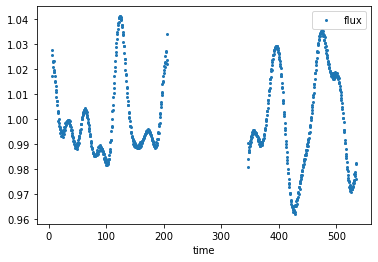

In [34]:
dummy = pd.read_csv(outpath+lc_out_path, sep='\t', names=['time', 'flux'], skiprows=1)
dummy.plot(x='time',y='flux', ls='', marker='o', ms=2)

### Periodogram analysis

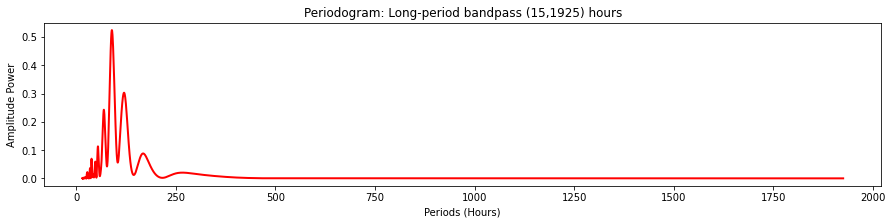

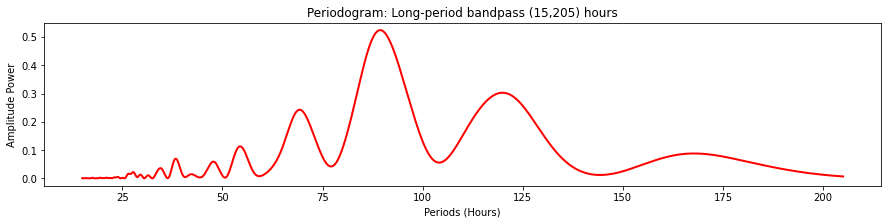

In [32]:
from PyAstronomy.pyTiming import pyPeriod
periodmax=1925
periodmin=15
frequen = np.linspace(1/periodmax,1/periodmin,10000)

# Compute the GLS periodogram with default options.
# Choose Zechmeister-Kuerster normalization explicitly
llp = pyPeriod.Gls((longPeriod_lc.time, longPeriod_lc.flux, 0.04*longPeriod_lc.flux), norm="ZK", freq=frequen,ofac=10)
fr = llp.freq
pw = llp.power
hpp = 1./fr

plt.close(), plt.figure(figsize=(15,3))
plt.plot(hpp, pw, '-', linewidth=2, alpha=1.0, c='r')
plt.ylabel('Amplitude Power'), plt.xlabel('Periods (Hours)')
plt.title('Periodogram: Long-period bandpass (%i,%i) hours'%(periodmin, periodmax))

periodmax=205
periodmin=15
frequen = np.linspace(1/periodmax,1/periodmin,10000)

# Compute the GLS periodogram with default options.
# Choose Zechmeister-Kuerster normalization explicitly
llp = pyPeriod.Gls((longPeriod_lc.time, longPeriod_lc.flux, 0.04*longPeriod_lc.flux), norm="ZK", freq=frequen,ofac=10)
fr = llp.freq
pw = llp.power
hpp = 1./fr

plt.figure(figsize=(15,3))
plt.plot(hpp, pw, '-', linewidth=2, alpha=1.0, c='r')
plt.ylabel('Amplitude Power'), plt.xlabel('Periods (Hours)')
plt.title('Periodogram: Long-period bandpass (%i,%i) hours'%(periodmin, periodmax))

### FOR SHORT PERIOD
frequen = np.linspace(1/9,1/4,1000)

# Compute the GLS periodogram with default options.
# Choose Zechmeister-Kuerster normalization explicitly
llp = pyPeriod.Gls((longPeriod_lc.time, longPeriod_lc.flux, 0.04*longPeriod_lc.flux), norm="ZK", freq=frequen,ofac=10)
fr = llp.freq
pw = llp.power
hpp = 1./fr

# plt.figure(figsize=(15,3))
# plt.plot(hpp, pw, '-', linewidth=2, alpha=1.0, c='r')
# plt.ylabel('Amplitude Power'), plt.xlabel('Periods (Hours)')
# plt.title('Periodogram: Long-period bandpass (%i,%i) hours'%(0, 15))
# # plt.xlim((15,75)), 
# plt.ylim((0, 0.002))

# Fourier Bandpass: Keep 50-100h

##### Within this range is a strikingly uniform periodic variation but with different amplitudes (due to systematics?)

<bound method BaseEstimator.get_params of MinMaxScaler(feature_range=(0.9886056277779879, 1.0114646876772828))>


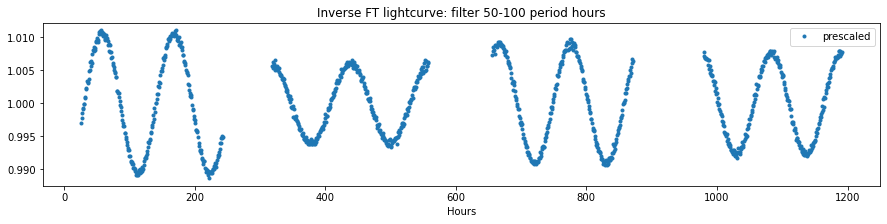

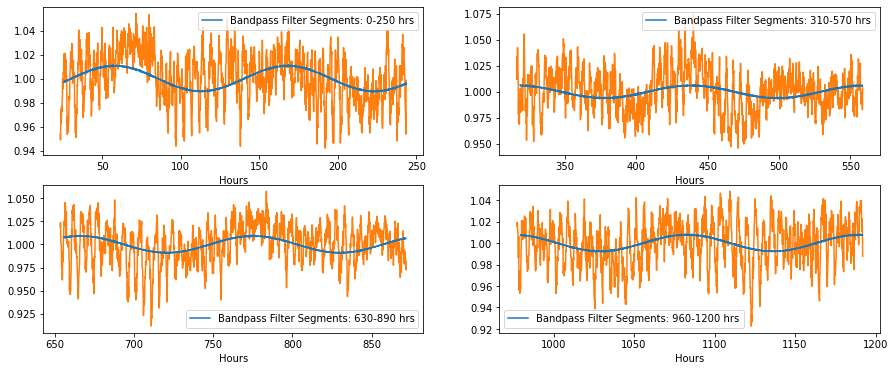

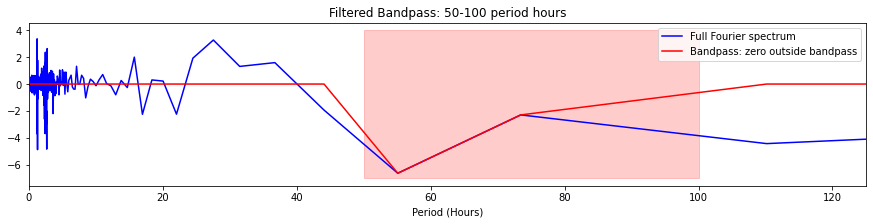

In [798]:
from scipy.fftpack import rfft, irfft, fftfreq
from scipy.interpolate import interp1d
from sklearn.preprocessing import MinMaxScaler #MinMaxScaler(feature_range=(0, 1), *, copy=True, clip=False)
segments = [(0, 250), (310, 570), (630, 890), (960, 1200)]

plt.close()
%matplotlib inline
f, ax = plt.subplots(figsize=(15,3))
tempTime, tempData = [], []
fig = plt.figure(figsize=(15, 6))

ReScaling = False

for i,seg in enumerate(segments):
    t0, t1 = seg[0], seg[1]
    subset = data.query('TIME >= %f & TIME < %f'%(t0, t1))
    realTime, realLc = subset.TIME, subset.PSF_FLUX_NORM
    cadence = 0.166668 # hours

    # synthetic time array and interpolated data
    synTime = np.arange(start=realTime.iloc[0], stop=realTime.iloc[-1], step=cadence)
    N = len(synTime)
    finterp = interp1d(x=realTime, y=realLc, kind = 'cubic')
    synLc = finterp(synTime)
    
    # fourier tranform
    yf = rfft(synLc)
    xf_period = 1/fftfreq(N, cadence)
    xf_freq = fftfreq(N, cadence)

    limlow, limhigh = 50, 100 # period hours, targets periods to extract
    boxcarwindow = 15 # period hours, to be smoothed out
    # filtering    
    yf_fil = yf.copy()
    # bandpass filter
    yf_fil[xf_period<0] = 0
    yf_fil[np.logical_and(xf_period>limlow, xf_period<limhigh)] = 0
    yf_fil[np.logical_and(xf_period>-limhigh, xf_period<-limlow)] = 0
    
    # subtract bandpass to get target extraction
    yf_filtered = yf-yf_fil
    filteredLc = pd.DataFrame(irfft(yf_filtered))
    
    rolled_filteredLc = 1+filteredLc.rolling(boxcarwindow).mean()
    limmin, limmax = rolled_filteredLc.min()[0], rolled_filteredLc.max()[0]
    
    if i == 0: # do: 1. get the rescaler function. 2. plot fourier spectrum and plot filter bandpass
        #### 1. min-max rescaler
        scaler = MinMaxScaler(feature_range=(limmin, limmax))
        
        #### 2. plot frequency spectrum
        figure, axe = plt.subplots(figsize=(15, 3))
        axe.set_title('Filtered Bandpass: %i-%i period hours'%(limlow, limhigh))
        axe.plot(xf_period, yf, 'b', label='Full Fourier spectrum')
        axe.plot(xf_period, yf_filtered, 'r', label='Bandpass: zero outside bandpass')
        plt.xlim((0,limhigh+25))
        axe.set_xlabel('Period (Hours)')
        rect = plt.Rectangle((limlow, -7), limhigh-limlow, 4--7, color='r', alpha=0.2)
        axe.add_patch(rect)
        axe.legend()
        
    ## plot inverse transform of the frequency-filtered lightcurve
    axes = fig.add_subplot(2, 2, i+1)
    axes.plot(realTime, realLc, c='tab:orange')
    axes.plot(synTime, rolled_filteredLc, c='tab:blue', label='Bandpass Filter Segments: %i-%i hrs'%(t0, t1))
    axes.set_xlabel('Hours')
    axes.legend()
        
    ## PLOT the whole lightcurve
    # ax.plot(synTime, 1+filteredLc.rolling(boxcarwindow).mean(), ls='', marker='o', ms=3, c='tab:blue')
    ax.plot(synTime[::5], rolled_filteredLc[::5], ls='', marker='o', ms=3, c='tab:blue', label='prescaled', alpha=1)
    if ReScaling:
        scaler.fit(rolled_filteredLc[::5])
        transformedLc = scaler.transform(rolled_filteredLc[::5])
        ax.plot(synTime[::5], transformedLc, ls='', marker='o', ms=3, c='tab:red', label='post-scaled', alpha=0.5)
    ax.set_xlabel('Hours')
    ax.set_title('Inverse FT lightcurve: filter %i-%i period hours'%(limlow, limhigh))
    if i==0:
        ax.legend()
        print(scaler.get_params)
    
    temparray = 1+rolled_filteredLc[::5]
    tempTime+=list(synTime[::5])
    tempData+=np.transpose(temparray.values).tolist()[0]
    
    

### Rescaler factor: apply to all bandpass-ed lightcurve 
#### Use the 50-100h range as rescaler factor for entire light curve with the `scipy.preprocessing.MinMaxScaler` method
(Essentially linear transform)

<bound method BaseEstimator.get_params of MinMaxScaler(feature_range=(0.9886056277779879, 1.0114646876772828))>


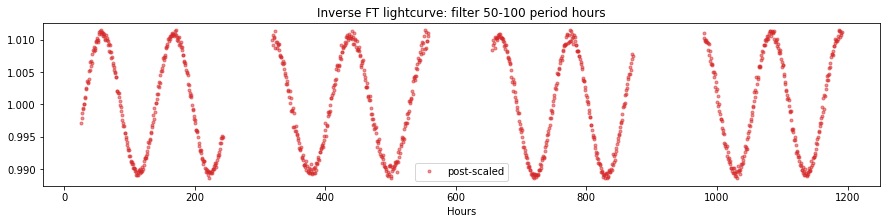

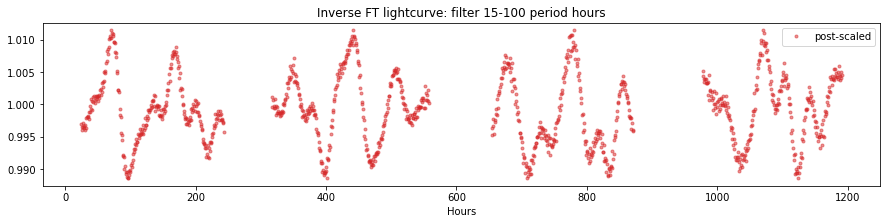

In [220]:
from scipy.fftpack import rfft, irfft, fftfreq
from scipy.interpolate import interp1d
from sklearn.preprocessing import MinMaxScaler #MinMaxScaler(feature_range=(0, 1), *, copy=True, clip=False)
segments = [(0, 250), (310, 570), (630, 890), (960, 1200)]

plt.close()
%matplotlib inline

#######################################################################################
### The 50-100 range
### Get rescaler information
#######################################################################################
f, ax = plt.subplots(figsize=(15,3))
tempTime, tempData = [], []
# fig = plt.figure(figsize=(15, 6))

for i,seg in enumerate(segments):
    t0, t1 = seg[0], seg[1]
    subset = data.query('TIME >= %f & TIME < %f'%(t0, t1))
    realTime, realLc = subset.TIME, subset.PSF_FLUX_NORM
    cadence = 0.166668 # hours

    # synthetic time array and interpolated data
    synTime = np.arange(start=realTime.iloc[0], stop=realTime.iloc[-1], step=cadence)
    N = len(synTime)
    finterp = interp1d(x=realTime, y=realLc, kind = 'cubic')
    synLc = finterp(synTime)
    
    # fourier tranform
    yf = rfft(synLc)
    xf_period = 1/fftfreq(N, cadence)
    xf_freq = fftfreq(N, cadence)

    limlow, limhigh = 50, 100 # period hours, targets periods to extract
    boxcarwindow = 15 # period hours, to be smoothed out
    # filtering    
    yf_fil = yf.copy()
    # bandpass filter
    yf_fil[xf_period<0] = 0
    yf_fil[np.logical_and(xf_period>limlow, xf_period<limhigh)] = 0
    yf_fil[np.logical_and(xf_period>-limhigh, xf_period<-limlow)] = 0
    
    # subtract bandpass to get target extraction
    yf_filtered = yf-yf_fil
    filteredLc = pd.DataFrame(irfft(yf_filtered))
    
    rolled_filteredLc = 1+filteredLc.rolling(boxcarwindow).mean()
    limmin, limmax = rolled_filteredLc.min()[0], rolled_filteredLc.max()[0]
    
    if i == 0: # do: 1. get the rescaler function. 2. plot fourier spectrum and plot filter bandpass
        #### 1. min-max rescaler
        scaler = MinMaxScaler(feature_range=(limmin, limmax))
        
    # ## plot inverse transform of the frequency-filtered lightcurve
    # if i<2:
    #     axes = fig.add_subplot(2, 2, i+1)
    #     axes.plot(realTime, realLc, c='tab:orange')
    #     axes.plot(synTime, rolled_filteredLc, c='tab:blue', label='Bandpass Filter Segments: %i-%i hrs'%(t0, t1))
    #     axes.set_xlabel('Hours')
    #     axes.legend()
        
    ## PLOT the whole lightcurve
    scaler.fit(rolled_filteredLc[::5])
    transformedLc = scaler.transform(rolled_filteredLc[::5])
    ax.plot(synTime[::5], transformedLc, ls='', marker='o', ms=3, c='tab:red', label='post-scaled', alpha=0.5)
    ax.set_xlabel('Hours')
    ax.set_title('Inverse FT lightcurve: filter %i-%i period hours'%(limlow, limhigh))
    if i==0:
        ax.legend()
        print(scaler.get_params)
    
    temparray = 1+rolled_filteredLc[::5]
    tempTime+=list(synTime[::5])
    tempData+=np.transpose(temparray.values).tolist()[0]

#######################################################################################
### The 30-100 range
#######################################################################################

# f, ax = plt.subplots(figsize=(15,3))
# tempTime, tempData = [], []
# # fig = plt.figure(figsize=(15, 6))

# for i,seg in enumerate(segments):
#     t0, t1 = seg[0], seg[1]
#     subset = data.query('TIME >= %f & TIME < %f'%(t0, t1))
#     realTime, realLc = subset.TIME, subset.PSF_FLUX_NORM
#     cadence = 0.166668 # hours

#     # synthetic time array and interpolated data
#     synTime = np.arange(start=realTime.iloc[0], stop=realTime.iloc[-1], step=cadence)
#     N = len(synTime)
#     finterp = interp1d(x=realTime, y=realLc, kind = 'cubic')
#     synLc = finterp(synTime)
    
#     # fourier tranform
#     yf = rfft(synLc)
#     xf_period = 1/fftfreq(N, cadence)
#     xf_freq = fftfreq(N, cadence)

#     limlow, limhigh = 30, 100 # period hours, targets periods to extract
#     boxcarwindow = 15 # period hours, to be smoothed out
#     # filtering    
#     yf_fil = yf.copy()
#     # bandpass filter
#     yf_fil[xf_period<0] = 0
#     yf_fil[np.logical_and(xf_period>limlow, xf_period<limhigh)] = 0
#     yf_fil[np.logical_and(xf_period>-limhigh, xf_period<-limlow)] = 0
    
#     # subtract bandpass to get target extraction
#     yf_filtered = yf-yf_fil
#     filteredLc = pd.DataFrame(irfft(yf_filtered))
    
#     rolled_filteredLc = 1+filteredLc.rolling(boxcarwindow).mean()
#     limmin, limmax = rolled_filteredLc.min()[0], rolled_filteredLc.max()[0]
        
#     ## PLOT the whole lightcurve
#     ## Reuse rescaler from 50-100h range
#     scaler.fit(rolled_filteredLc[::5])
#     transformedLc = scaler.transform(rolled_filteredLc[::5])
#     ax.plot(synTime[::5], transformedLc, ls='', marker='o', ms=3, c='tab:red', label='post-scaled', alpha=0.5)
#     ax.set_xlabel('Hours')
#     ax.set_title('Inverse FT lightcurve: filter %i-%i period hours'%(limlow, limhigh))
#     if i==0:
#         ax.legend()
    
#     temparray = 1+rolled_filteredLc[::5]
#     tempTime+=list(synTime[::5])
#     tempData+=np.transpose(temparray.values).tolist()[0]
    
#######################################################################################
### The 15-100 range
#######################################################################################
longPeriod_lc_scaled = pd.DataFrame()
f, ax = plt.subplots(figsize=(15,3))
tempTime, tempData = [], []
# fig = plt.figure(figsize=(15, 6))

for i,seg in enumerate(segments):
    t0, t1 = seg[0], seg[1]
    subset = data.query('TIME >= %f & TIME < %f'%(t0, t1))
    realTime, realLc = subset.TIME, subset.PSF_FLUX_NORM
    cadence = 0.166668 # hours

    # synthetic time array and interpolated data
    synTime = np.arange(start=realTime.iloc[0], stop=realTime.iloc[-1], step=cadence)
    N = len(synTime)
    finterp = interp1d(x=realTime, y=realLc, kind = 'cubic')
    synLc = finterp(synTime)
    
    # fourier tranform
    yf = rfft(synLc)
    xf_period = 1/fftfreq(N, cadence)
    xf_freq = fftfreq(N, cadence)

    limlow, limhigh = 15, 100 # period hours, targets periods to extract
    # limlow, limhigh = 15, 60 # period hours, targets periods to extract
    boxcarwindow = 5 # period hours, to be smoothed out
    # filtering    
    yf_fil = yf.copy()
    # bandpass filter
    yf_fil[xf_period<0] = 0
    yf_fil[np.logical_and(xf_period>limlow, xf_period<limhigh)] = 0
    yf_fil[np.logical_and(xf_period>-limhigh, xf_period<-limlow)] = 0
    
    # subtract bandpass to get target extraction
    yf_filtered = yf-yf_fil
    filteredLc = pd.DataFrame(irfft(yf_filtered))
    
    rolled_filteredLc = 1+filteredLc.rolling(boxcarwindow).mean()
    limmin, limmax = rolled_filteredLc.min()[0], rolled_filteredLc.max()[0]
        
    ## PLOT the whole lightcurve
    ## Reuse rescaler from 50-100h range
    scaler.fit(rolled_filteredLc[::5])
    transformedLc = scaler.transform(rolled_filteredLc[::5])
    ax.plot(synTime[::5], transformedLc, ls='', marker='o', ms=3, c='tab:red', label='post-scaled', alpha=0.5)
    ax.set_xlabel('Hours')
    ax.set_title('Inverse FT lightcurve: filter %i-%i period hours'%(limlow, limhigh))
    if i==0:
        ax.legend()
    
    temparray = transformedLc
    tempTime+=list(synTime[::5])
    tempData+=np.transpose(temparray).tolist()[0]
    
longPeriod_lc_scaled['time'] = np.array(tempTime)
longPeriod_lc_scaled['flux'] = np.array(tempData)

#######################################################################################
### The 15-60 range
#######################################################################################

# f, ax = plt.subplots(figsize=(15,3))
# tempTime, tempData = [], []
# # fig = plt.figure(figsize=(15, 6))

# for i,seg in enumerate(segments):
#     t0, t1 = seg[0], seg[1]
#     subset = data.query('TIME >= %f & TIME < %f'%(t0, t1))
#     realTime, realLc = subset.TIME, subset.PSF_FLUX_NORM
#     cadence = 0.166668 # hours

#     # synthetic time array and interpolated data
#     synTime = np.arange(start=realTime.iloc[0], stop=realTime.iloc[-1], step=cadence)
#     N = len(synTime)
#     finterp = interp1d(x=realTime, y=realLc, kind = 'cubic')
#     synLc = finterp(synTime)
    
#     # fourier tranform
#     yf = rfft(synLc)
#     xf_period = 1/fftfreq(N, cadence)
#     xf_freq = fftfreq(N, cadence)

#     limlow, limhigh = 15, 60 # period hours, targets periods to extract
#     boxcarwindow = 5 # period hours, to be smoothed out
#     # filtering    
#     yf_fil = yf.copy()
#     # bandpass filter
#     yf_fil[xf_period<0] = 0
#     yf_fil[np.logical_and(xf_period>limlow, xf_period<limhigh)] = 0
#     yf_fil[np.logical_and(xf_period>-limhigh, xf_period<-limlow)] = 0
    
#     # subtract bandpass to get target extraction
#     yf_filtered = yf-yf_fil
#     filteredLc = pd.DataFrame(irfft(yf_filtered))
    
#     rolled_filteredLc = 1+filteredLc.rolling(boxcarwindow).mean()
#     limmin, limmax = rolled_filteredLc.min()[0], rolled_filteredLc.max()[0]
        
#     ## PLOT the whole lightcurve
#     ## Reuse rescaler from 50-100h range
#     scaler.fit(rolled_filteredLc[::5])
#     transformedLc = scaler.transform(rolled_filteredLc[::5])
#     ax.plot(synTime[::5], transformedLc, ls='', marker='o', ms=3, c='tab:red', label='post-scaled', alpha=0.5)
#     ax.set_xlabel('Hours')
#     ax.set_title('Inverse FT lightcurve: filter %i-%i period hours'%(limlow, limhigh))
#     if i==0:
#         ax.legend()
    
#     temparray = 1+rolled_filteredLc[::5]
#     tempTime+=list(synTime[::5])
#     tempData+=np.transpose(temparray.values).tolist()[0]

### AUTOCORRELATION

(2676,)


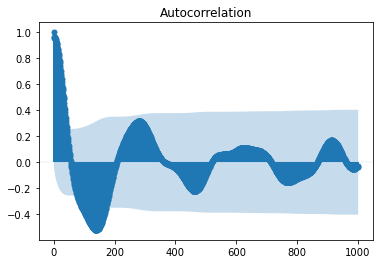

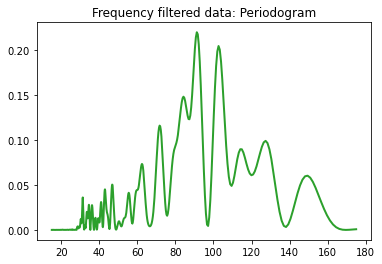

<Figure size 432x288 with 0 Axes>

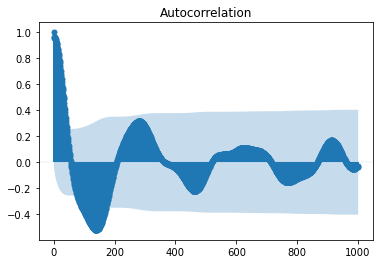

In [181]:
array = pd.DataFrame(np.transpose([tempTime, tempData]))
array.dropna(inplace=True)
tlg, datalg = array[0], array[1]

edatalg = datalg*0.04
clp = pyPeriod.Gls((tlg,datalg,edatalg), norm="ZK", freq=frequen,ofac=10)
fr, pw = clp.freq, clp.power
hpp = 1./fr
plt.close(), plt.figure(), plt.title('Frequency filtered data: Periodogram')
plt.plot(hpp,pw, c='tab:green', lw=2.0, label = 'Whole lightcurve')

plt.figure()
print(datalg.shape)
plot_acf(datalg, lags=1000, lw=0.1)
# regressionTrend = -tlg*2e-6
# datalg -= regressionTrend

### MANUAL EXPERIMENT: GAUSSIAN PLOTS

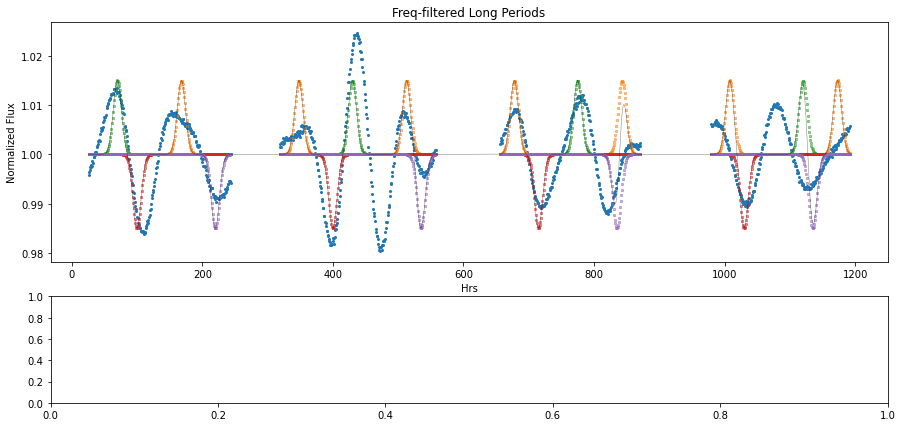

In [732]:
%matplotlib inline
plt.close()

def repeat_gaussian(x, T, mu, fwhm, offset):
    sigma=fwhm/2.355
    y = np.zeros(x.shape)
    repeat = 15
    for i, val in enumerate(x):
        for c in range(repeat):
            d = c-1
            if d<0: d=0
            y[i] += gauss(val, mu + c*T + d*offset, sigma)
    ymax = np.max(y)
    y/=ymax
    return np.array(y)

C = 1

f, (ax0, ax1) = plt.subplots(2, 1, figsize=(15, 7), gridspec_kw={'height_ratios': [1.8, 0.8]})

ax0.plot(tlg, datalg, ls='', marker='o', ms=2.0)

y = (0.015*repeat_gaussian(x=tlg, T=180, mu=168, fwhm=35, offset=-15))
ax0.plot(tlg, C+y, ls='', marker='s', ms=2., alpha=0.5)

y2= (0.015*repeat_gaussian(x=tlg, T=360, mu=70, fwhm=35, offset=-15))
ax0.plot(tlg, C+y2, ls='', marker='s', ms=2., alpha=0.5)

y3= (-0.015*repeat_gaussian(x=tlg, T=300, mu=100, fwhm=35, offset=+15))
ax0.plot(tlg, C+y3, ls='', marker='s', ms=2., alpha=0.5)

y4= (-0.015*repeat_gaussian(x=tlg, T=315, mu=220, fwhm=35, offset=-15))
ax0.plot(tlg, C+y4, ls='', marker='s', ms=2., alpha=0.5)

sum0 = C+ y +y2 + y3 + y4
ax0.plot(tlg, sum0, ls='-', lw=0.5, c='k', alpha=0.5)

ax0.set_xlabel('Hrs'), ax0.set_ylabel('Normalized Flux'), ax0.set_title('Freq-filtered Long Periods')
plt.show()

### HYPER OPT FITS EXPERIMENTS

In [744]:
import sklearn 
from sklearn.metrics import mean_squared_error, r2_score
from hyperopt import hp, tpe, Trials, fmin
import time
from sklearn.model_selection import train_test_split
pi = np.pi

# random split the data into train and test
x_data = tlg
y_data = datalg
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.5, random_state=42)

# def objective(a0, a1, f1, a2, f2, a3, f3, w1, w2, w3):
#     """Objective function to minimize"""
#     return np.mean((a0+ a1 * np.sin(w1*X_train + f1) + a2 * np.sin(w2*X_train + f2) + a3 * np.sin(w3*X_train + f3) - y_train)**2)

def objective(a0, a1, f1, w1):
    """Objective function to minimize"""
    return np.mean((a0+ a1 * np.sin(w1*X_train + f1) - y_train)**2)


def objective2(args):
    return objective(*args)

seed = 12345512
np.random.seed(seed)

from hyperopt import hp, tpe, Trials, fmin
from IPython.display import display, Math
# bounds = [[0.99, 1.01],
#           [0, 0.2],
#           [-np.pi, np.pi],
#           [0, 0.2],
#           [-np.pi, np.pi],
#           [0, 0.2],
#           [-np.pi, np.pi],
#           [2*pi/100, 2*pi/85],
#           [2*pi/100, 2*pi/85],
#           [2*pi/65, 2*pi/50]]

bounds = [[0.99, 1.01],
          [0, 0.2],
          [-np.pi, np.pi],
          [2*pi/100, 2*pi/60]]

# space = [hp.uniform('a0', bounds[0][0], bounds[0][1]),
#          hp.uniform('a1', bounds[1][0], bounds[1][1]), 
#          hp.uniform('f1', bounds[2][0], bounds[2][1]),
#          hp.uniform('a2', bounds[3][0], bounds[3][1]), 
#          hp.uniform('f2', bounds[4][0], bounds[4][1]),
#          hp.uniform('a3', bounds[5][0], bounds[5][1]), 
#          hp.uniform('f3', bounds[6][0], bounds[6][1]),
#          hp.uniform('w1', bounds[7][0], bounds[7][1]),
#          hp.uniform('w2', bounds[8][0], bounds[8][1]),
#          hp.uniform('w3', bounds[9][0], bounds[9][1])]

space = [hp.uniform('a0', bounds[0][0], bounds[0][1]),
         hp.uniform('a1', bounds[1][0], bounds[1][1]), 
         hp.uniform('f1', bounds[2][0], bounds[2][1]),
         hp.uniform('w1', bounds[3][0], bounds[3][1])]
    
redo = True
# redo = False
maxevals = 5000

if redo:
    tpe_algo = tpe.suggest
    tpe_trials = Trials()
    tpe_best = fmin(fn=objective2, space=space, algo=tpe_algo, trials=tpe_trials, max_evals=maxevals, rstate=np.random.default_rng(seed))
    
#     handle_code = 'hyperOPT'
#     if known_freq: handle_case = 'limFreq'
#     else: handle_case = 'freeFreq'
#     folder = join(homedir,'notebooks', 'lightCurveFit_metadata')
#     filename = 'tpebestLongPeriod_%s_sector3637_%i_%i-hr_%s_fitMeta.pkl'%(handle_code, tlow, thigh, handle_case)
#     import pickle
#     with open(join(folder, filename), 'wb+') as file:
#         pickle.dump(tpe_best, file, protocol=pickle.HIGHEST_PROTOCOL)
# else:
#     with open(join(folder, filename), 'rb') as file:
#         tpe_read = pickle.load(file)
#     tpe_best = tpe_read.copy()
    
print('Fitted parameters:')
# display(Math('a_0={a0:.5f}, a_1={a1:.2e}, \\phi_1={f1:.2f}, a_2={a2:.2e}, \\phi_2={f2:.2f}, a_3={a3:.2e}, \\phi_3={f3:.2f}, \\omega_1={w1:.2f}, \\omega_2={w2:.2f}, \\omega_3={w3:.2f}'.format(**tpe_best)))

100%|█| 5000/5000 [03:31<00:00, 23.59trial/s, best loss: 4.8660635522447715e-05]
Fitted parameters:


KeyError: 'a2'

mse: 4.786968237999379e-05
r2: 0.2731161552107194
{'a0': 1.0003023506843047, 'a1': 0.006489029640674105, 'f1': 3.133970240272286, 'w1': 0.06915254517533265}


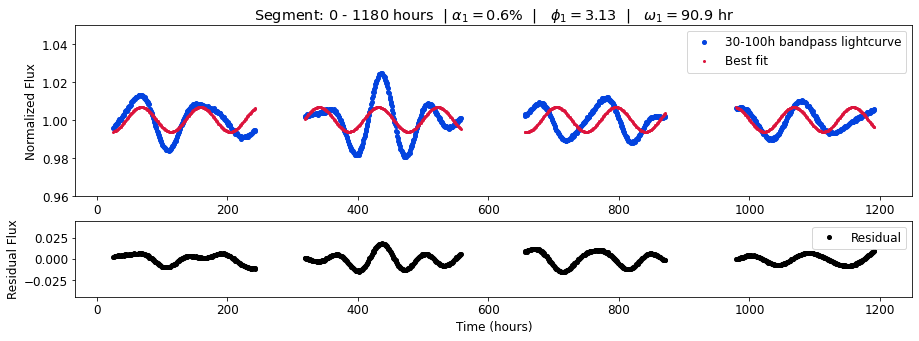

In [748]:
# Test
from sklearn.metrics import mean_squared_error, r2_score

# ypred = tpe_best['a0']+ tpe_best['a1'] * np.sin(tpe_best['w1'] * X_test + tpe_best['f1']) +tpe_best['a2'] * np.sin(tpe_best['w2'] * X_test + tpe_best['f2']) +tpe_best['a3'] * np.sin(tpe_best['w3'] * X_test + tpe_best['f3'])
# y =  tpe_best['a0'] + tpe_best['a1'] * np.sin(tpe_best['w1']* x_data + tpe_best['f1']) + tpe_best['a2'] * np.sin(tpe_best['w2'] * x_data + tpe_best['f2']) + tpe_best['a3'] * np.sin(tpe_best['w3'] * x_data + tpe_best['f3'])    

ypred = tpe_best['a0']+ tpe_best['a1'] * np.sin(tpe_best['w1'] * X_test + tpe_best['f1'])
y =  tpe_best['a0'] + tpe_best['a1'] * np.sin(tpe_best['w1']* x_data + tpe_best['f1'])

tpelist = [tpe_best[key] for key in tpe_best][1:]    

rmse = mean_squared_error(y_test,ypred)
r2 = r2_score(y_test,ypred)
print('mse:', rmse)
print('r2:',r2)

residual = y_data - y

tryFit_residual = False
if tryFit_residual: 
    def sine(a,w,f,t): return a*np.sin(w*t +f)
    guesses = [0.02, 2*pi/15, 0]
    limits = [(0.,0.05), (2*pi/30, 2*pi/5), (0, pi)]
    pfit, cov = curve_fit(sine, x_data, residual, p0=guesses, bounds=np.transpose(limits))
    residualFit = sine(pfit[0], pfit[1], pfit[2], x_data)

txtsize = 12
headersize = 15
lw_data=2.5
lw_other=2.5
ms=4

backgroundcolor = 'xkcd:orange'
backgroundalpha = 0.1    
### Plotting
plt.close()
import matplotlib
matplotlib.rcParams.update({'font.size': 12})

f, (a0, a1) = plt.subplots(2, 1, figsize = (15,5), gridspec_kw={'height_ratios': [1.8, 0.8]})
a0.plot(x_data, y_data, label='%i-%ih bandpass lightcurve'%(limlow, limhigh), ls='', marker='o', ms=ms, c='xkcd:blue')
a0.plot(x_data, y, label=r'Best fit',
        ls='', marker='o', ms=2, c='crimson')
a0.set_ylim((0.96, 1.05))
a0.set_ylabel('Normalized Flux')
# a0.set_xlabel('Time (hours)')

a0.legend()
# a0.set_title('Segment: %i - %i hours  | '%(tlow, thigh) + r'$\alpha_{1,2,3}=%.1f, %.1f, %.1f$%%' %(tpelist[0]*100, tpelist[1]*100, tpelist[2]*100) + 
#           r'  |   $\phi_{1,2,3}=%.2f, %.2f, %.2f$' %(tpelist[3], tpelist[4], tpelist[5]) +
#           r'  |   $\omega_{1,2,3}=%.1f, %.1f, %.1f$ hr'   %(2*pi/tpelist[6], 2*pi/tpelist[7], 2*pi/tpelist[8]) )

a0.set_title('Segment: %i - %i hours  | '%(tlow, thigh) + r'$\alpha_{1}=%.1f$%%' %(tpelist[0]*100) + 
          r'  |   $\phi_{1}=%.2f$' %(tpelist[1]) +
          r'  |   $\omega_{1}=%.1f$ hr'   %(2*pi/tpelist[2]) )

a1.plot(x_data, residual, label='Residual', ls='', marker='o', ms=4, c='k')
if tryFit_residual: plt.plot(x_data, residualFit, label='Fit: sine, (a=%.1f, P=%i hour, f=%.1f)'%(pfit[0]*100, 2*pi/pfit[1], pfit[2]), lw=1, c='b')
a1.legend()
a1.set_ylim((-0.045,0.045))
a1.set_xlabel('Time (hours)')
a1.set_ylabel('Residual Flux')

## Saving
# save = True
save = False

if save:
    handle_code = 'hyperOPT'
    if known_freq: handle_case = 'limFreq'
    else: handle_case = 'freeFreq'
    plotOut = plotPath + '/LongPeriod_%s_sector3637_%i_%i-hr_%s_fit'%(handle_code, tlow, thigh, handle_case)
    plt.savefig(plotOut+'.pdf', dpi=300, format='pdf', bbox_inches = 'tight')
    plt.savefig(plotOut+'.png', dpi=300, format='png', bbox_inches = 'tight')

# w1, w2, w3 = tpe_best['w1'], tpe_best['w2'], tpe_best['w3']
# print('Fitted parameters:')
# display(Math('a_0={a0:.5f}, a_1={a1:.2e}, \\phi_1={f1:.2f}, a_2={a2:.2e}, \\phi_2={f2:.2f}, a_3={a3:.2e}, \\phi_3={f3:.2f}, \\omega_1={w1:.2f}, \\omega_2={w2:.2f}, \\omega_3={w3:.2f}'.format(**tpe_best)))
    
# print('%.3f, %.3f, %.3f'%(2*pi/w1, 2*pi/w2, 2*pi/w3))
# print('%.3f, %.3f, %.3f'%(w1, w2, w3))
print(tpe_best)

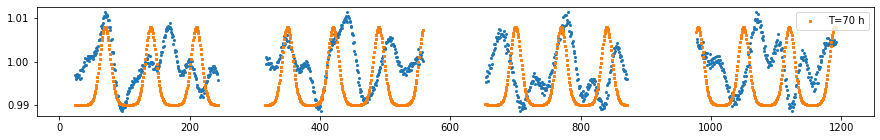

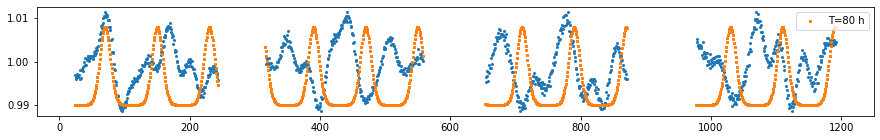

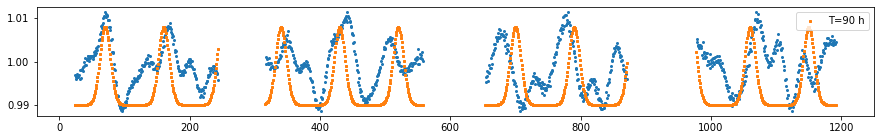

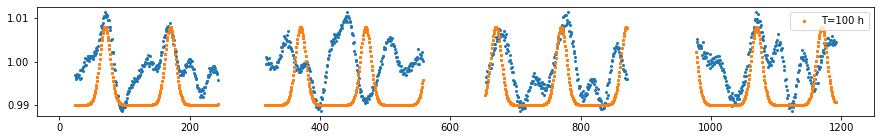

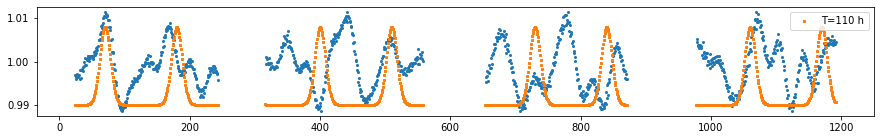

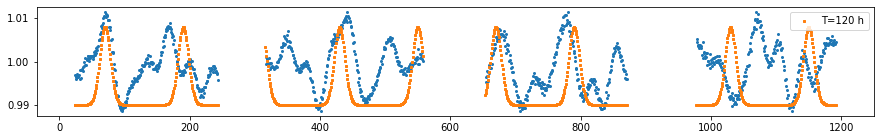

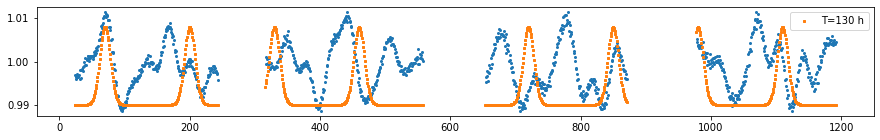

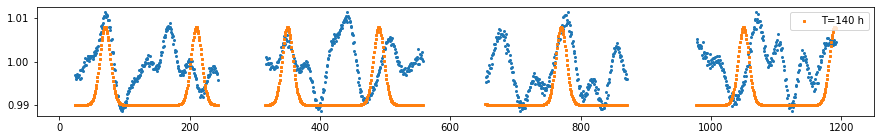

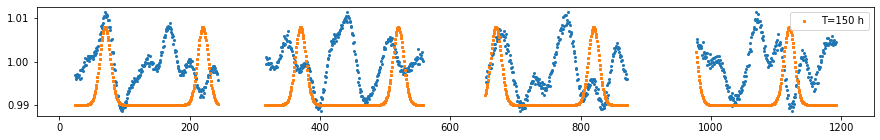

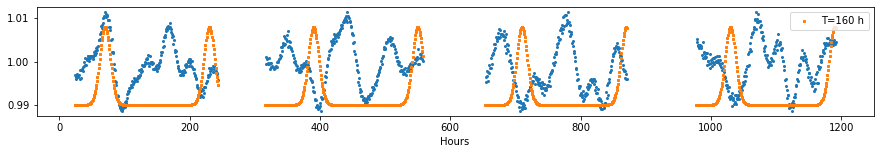

In [227]:
%matplotlib inline

# llc = longPeriod_lc.copy()
# llc = llc.iloc[::5]

## USING THE SCALED VERSION OF 15-100 light curve
### HAD TO RUN THE RESCALING CELL FIRST
llc = longPeriod_lc_scaled.copy()

# f, ax = plt.subplots(figsize=(15,3))
# ax.plot(llc.time, llc.flux, ls='', marker='.', ms=4)

from scipy.signal import find_peaks
peaks = find_peaks(llc.flux, distance=200)
peaks[0]

for value in llc.time[peaks[0]].values:
    ax.axvline(x=value, ymin=0.97, ymax=1.02, c='red', alpha=1)
ax.axhline(y=1, ls='-', lw=1, alpha=0.1, c='k')

def repeat_gaussian(x, T, mu, fwhm, offset):
    sigma=fwhm/2.355
    y = np.zeros(x.shape)
    repeat = 30
    for i, val in enumerate(x):
        for c in range(repeat):
            d = c-1
            if d<0: d=0
            y[i] += gauss(val, mu + c*T + d*offset, sigma)
    ymax = np.max(y)
    y/=ymax
    return np.array(y)

stepup=10
C=0.99
for i in range(10):
    if i==0: step=stepup
    f, ax = plt.subplots(figsize=(15,2))
    ax.plot(llc.time, llc.flux, ls='', marker='.', ms=4)
    period = 60+step 
    y = (0.018*repeat_gaussian(x=llc.time, T=period, mu=70, fwhm=45, offset=0))
    ax.plot(llc.time, C+y, ls='', marker='s', ms=2., alpha=1, label='T=%i h'%(period))
    ax.legend(loc='upper right')
    step+=stepup
ax.set_xlabel('Hours')
from scipy.fftpack import rfft, irfft, fftfreq
from scipy.interpolate import interp1d
segments = [(0, 250), (310, 570), (630, 890), (960, 1200)]
import warnings
warnings.filterwarnings("ignore")


### WAVELET TRANSFORM

##### Try out with example El Nino dataset

In [548]:
from scipy.fft import fft, ifft # fast fourier transform
import pywt # py wavelet transform 

%matplotlib widget

def plot_wavelet(time, signal, scales, 
                 waveletname = 'cgau1', 
                 cmap = plt.cm.viridis, 
                 title = 'Wavelet Transform (Power Spectrum) of signal', 
                 ylabel = 'Period (hours)', 
                 xlabel = 'Time (hrs)'):
    
    dt = time[1] - time[0]
    [coefficients, frequencies] = pywt.cwt(signal, scales, waveletname, dt)
    power = (abs(coefficients)) ** 2
    period = 1. / frequencies
    levels = [1e-6, 2e-6, 5e-6, 8e-6, 1e-5, 2e-5, 5e-5, 1e-4, 2e-4, 5e-4, 1e-3, 2e-3, 5e-3, 8e-3, 1e-2, 5e-2, 8e-2, 1e-1]
    contourlevels = np.log2(levels)
    
    fig, ax = plt.subplots(figsize=(15, 10))
    im = ax.contourf(time, np.log2(period), np.log2(power), contourlevels, extend='both',cmap=cmap)
    
    ax.set_title(title, fontsize=20)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    
    yticks = 2**np.arange(np.ceil(np.log2(period.min())), np.ceil(np.log2(period.max())))
    ax.set_yticks(np.log2(yticks))
    ax.set_yticklabels(yticks)
    ax.invert_yaxis()
    ylim = ax.get_ylim()
    ax.set_ylim(ylim[0], -1)
    ax.set_xlim(0,1190)
    
    cbar_ax = fig.add_axes([0.95, 0.5, 0.03, 0.25])
    fig.colorbar(im, cax=cbar_ax, orientation="vertical")
    plt.show()

def get_ave_values(time, signal, average_over):
    data = pd.DataFrame(np.transpose((time,signal)), columns=['time', 'signal'])
    data = data.rolling(average_over).mean()
    return data.time.values, data.signal.values
    
def plot_signal_plus_average(time, signal, average_over = 5):
    fig, ax = plt.subplots(figsize=(15, 3))
    time_ave, signal_ave = get_ave_values(time, signal, average_over)
    ax.plot(time, signal, label='signal')
    ax.plot(time_ave, signal_ave, label = 'time average (n={})'.format(5))
    ax.set_xlim([time[0], 0.6*time[-1]])
    ax.set_ylabel('Signal Amplitude', fontsize=18)
    ax.set_title('Signal + Time Average', fontsize=18)
    ax.set_xlabel('Time', fontsize=18)
    ax.set_xlim(0,1190)
    ax.legend()
    plt.show()
    
def get_fft_values(y_values, T, N, f_s):
    f_values = np.linspace(0.0, 1.0/(2.0*T), N//2)
    fft_values_ = fft(y_values)
    fft_values = 2.0/N * np.abs(fft_values_[0:N//2])
    return f_values, fft_values

def plot_fft_plus_power(time, signal):
    dt = time[1] - time[0]
    N = len(signal)
    fs = 1/dt
    
    fig, ax = plt.subplots(figsize=(15, 3))
    variance = np.std(signal)**2
    f_values, fft_values = get_fft_values(signal, dt, N, fs)
    fft_power = variance * abs(fft_values) ** 2     # FFT power spectrum
    ax.plot(1/f_values, fft_values, 'r-', label='Fourier Transform')
    ax.plot(1/f_values, fft_power, 'k--', linewidth=1, label='FFT Power Spectrum')
    ax.set_xlabel('Frequency [(Period hours) / Time hour]', fontsize=18)
    ax.set_ylabel('Amplitude', fontsize=18)
    ax.set_xlim((0,250))
    ax.legend()
    plt.show()
    
# dataset = "http://paos.colorado.edu/research/wavelets/wave_idl/sst_nino3.dat"
# df_nino = pd.read_table(dataset)
# N = df_nino.shape[0]
# t0=1871
# dt=0.25
# time = np.arange(0, N) * dt + t0
# signal = df_nino.values.squeeze()

# scales = np.arange(1, 128)
# plot_signal_plus_average(time, signal)
# plot_fft_plus_power(time, signal)
# plot_wavelet(time, signal, scales)

##### Then our long-period data

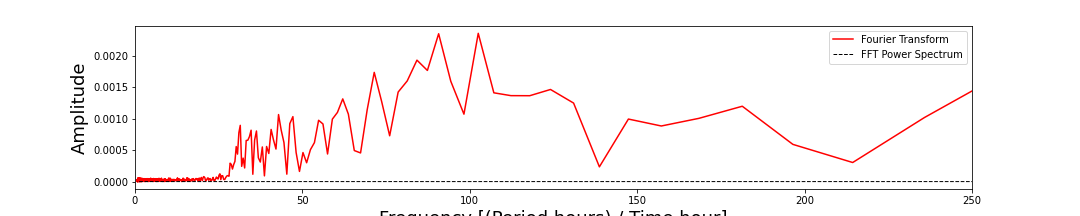

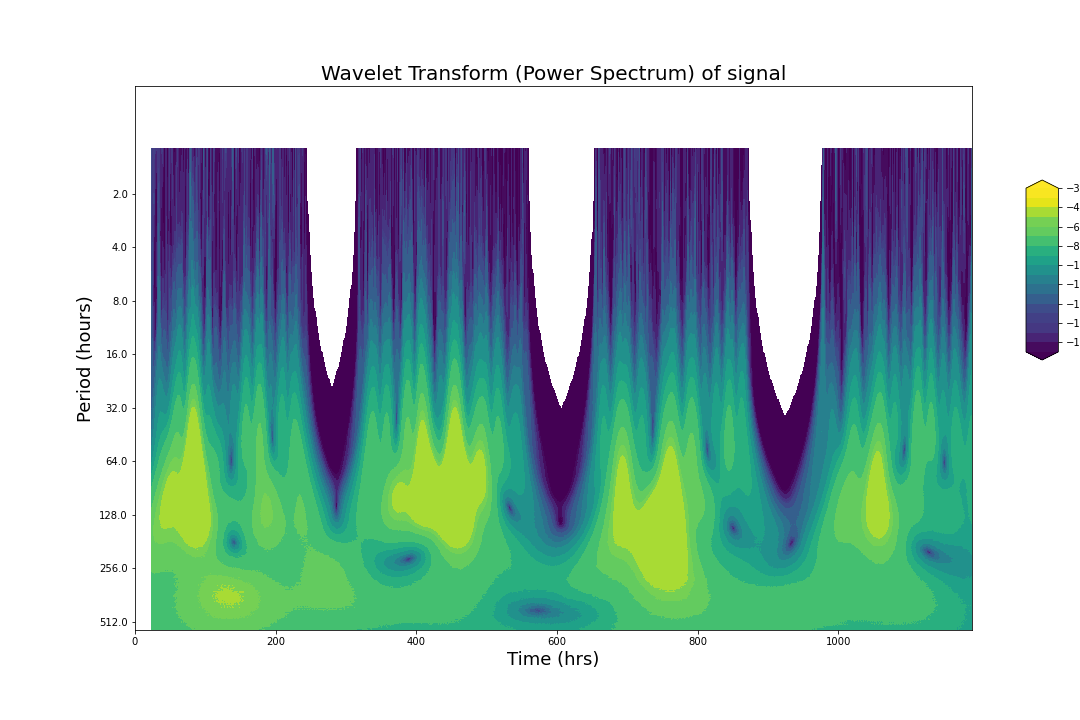

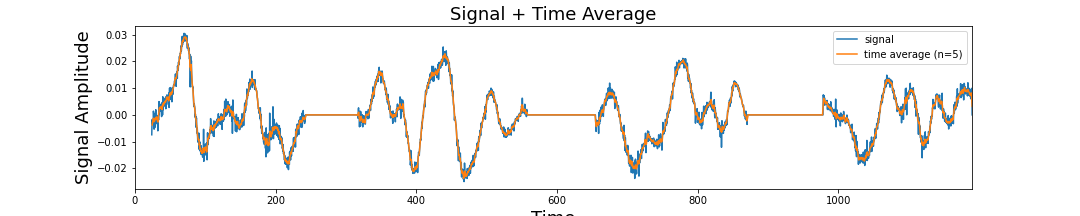

In [549]:
%matplotlib widget
t0, t1 = segments[0][0], segments[3][1]
subset = longPeriod_lc.query('time >= %f & time < %f'%(t0, t1)) 

N = subset.shape[0]
time = subset.time.values
signal = subset.flux.values

### synthetic time array and interpolated data
### Make synthetic time array extra long to leave room for partial correlation
dt = subset.time.diff().median()
time_array = np.arange(start=longPeriod_lc.time.iloc[0], stop=2*longPeriod_lc.time.iloc[-1], step=dt)
finterp = interp1d(x=longPeriod_lc.time, y=longPeriod_lc.flux, kind = 'cubic', fill_value='extrapolate')
longInterp_flux = finterp(time_array) -1

### Data gaps equal signal 0
cond1 = np.where(np.logical_and(time_array>242.50, time_array<317.03))[0]
cond2 = np.where(np.logical_and(time_array>557.25, time_array<654.79))[0]
cond3 = np.where(np.logical_and(time_array>870.66, time_array<978.18))[0]
longInterp_flux[cond1] = 0
longInterp_flux[cond2] = 0
longInterp_flux[cond3] = 0
longInterp_flux[time_array>1190] = 0

# ### Plot and compare data
# plt.close(), plt.figure(figsize=(15,3))
# plt.plot(longPeriod_lc.time, longPeriod_lc.flux-1, ls='', marker='o', ms=5)
# plt.plot(time_array, longInterp_flux, lw=0.5)
# time_array.size, longPeriod_lc.time.size

### Plot spectrogram and Fourier Transform
scales = np.arange(1, 512)
plot_fft_plus_power(time_array, longInterp_flux)
plot_wavelet(time_array, longInterp_flux, scales)
plot_signal_plus_average(time_array, longInterp_flux)

In [529]:
print(pywt.ContinuousWavelet('cmor'))
print(pywt.ContinuousWavelet('gaus1'))
print(pywt.ContinuousWavelet('mexh'))
print(pywt.ContinuousWavelet('morl'))
print(pywt.ContinuousWavelet('cgau1'))
print(pywt.ContinuousWavelet('shan'))
print(pywt.ContinuousWavelet('fbsp'))

ContinuousWavelet cmor
  Family name:    Complex Morlet wavelets
  Short name:     cmor
  Symmetry:       asymmetric
  DWT:            False
  CWT:            True
  Complex CWT:    True
ContinuousWavelet gaus1
  Family name:    Gaussian
  Short name:     gaus
  Symmetry:       anti-symmetric
  DWT:            False
  CWT:            True
  Complex CWT:    False
ContinuousWavelet mexh
  Family name:    Mexican hat wavelet
  Short name:     mexh
  Symmetry:       symmetric
  DWT:            False
  CWT:            True
  Complex CWT:    False
ContinuousWavelet morl
  Family name:    Morlet wavelet
  Short name:     morl
  Symmetry:       symmetric
  DWT:            False
  CWT:            True
  Complex CWT:    False
ContinuousWavelet cgau1
  Family name:    Complex Gaussian wavelets
  Short name:     cgau
  Symmetry:       anti-symmetric
  DWT:            False
  CWT:            True
  Complex CWT:    True
ContinuousWavelet shan
  Family name:    Shannon wavelets
  Short name:     shan

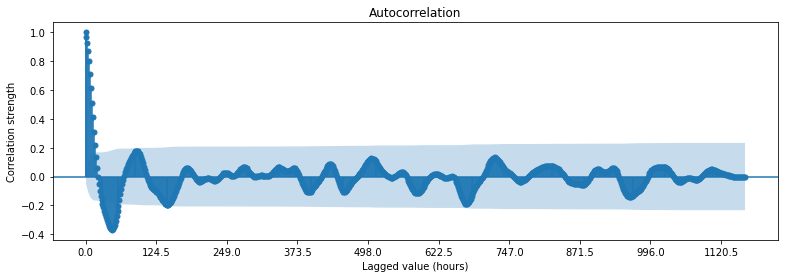

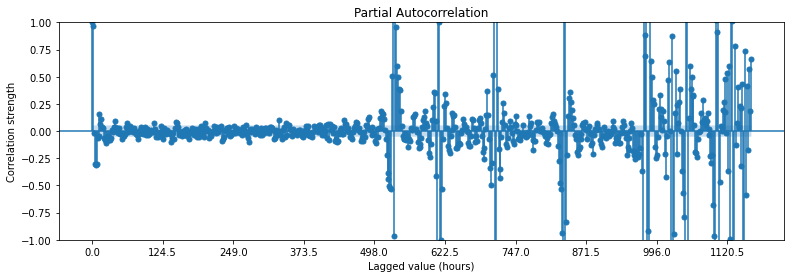

In [479]:
### Autocorrelation
%matplotlib inline

skip = 5
dskip = np.half(np.diff(time_array[::skip])[0])
dskip = 1.66
lag = 700
ticksarr = np.array([0, 75, 150, 225, 300, 375, 450, 525, 600, 675])

from statsmodels.graphics import tsaplots
fig, ax = plt.subplots(figsize=(13,4))
tsaplots.plot_acf(longInterp_flux[::skip], lags=lag, ax=ax)
ax.set_xticks(list(ticksarr))
ax.set_xticklabels(list(ticksarr*dskip))
ax.set_xlabel('Lagged value (hours)'), ax.set_ylabel('Correlation strength')
plt.show()

fig2, ax2 = plt.subplots(figsize=(13,4))
tsaplots.plot_pacf(longInterp_flux[::skip], lags=lag, ax=ax2)
ax2.set_xticks(list(ticksarr))
ax2.set_xticklabels(list(ticksarr*dskip))
ax2.set_xlabel('Lagged value (hours)'), ax2.set_ylabel('Correlation strength')
ax2.set_ylim((-1, 1))
plt.show()